# Clipper Client

In [1]:
#imports
from __future__ import print_function
from clipper_admin import ClipperConnection, KubernetesContainerManager, DockerContainerManager
from clipper_admin.deployers.pytorch import deploy_pytorch_model
from clipper_admin.deployers import python as python_deployer
import json
import requests
from datetime import datetime
import time
import numpy as np
import signal
import sys
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim

In [2]:
#making the api requests in this function
def predict(addr, x, batch=False):
    url = "http://%s/pytorch-example-2/predict" % addr
    if batch:
        req_json = json.dumps({'input_batch': [x]})
    else:
        print('going to non batch')
        print(x[0])
        print(type(x[0]))
        print(type(x[0]))
        req_json = json.dumps({'input': x})
    headers = {'Content-type': 'application/json'}
    start = datetime.now()
    # print('sending request')
    r = requests.post(url, headers=headers, data=req_json)
    # print('after request')
    end = datetime.now()
    latency = (end - start).total_seconds() * 1000.0
    print("%f ms" % (latency))
    return latency

In [3]:
#loading the test data
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [4]:
#Connecting to Clipper
clipper_conn = ClipperConnection(KubernetesContainerManager(useInternalIP=True))
clipper_conn.connect()

18-06-19:15:25:45 WARNING  [kubernetes_container_manager.py:231] No external node addresses found. Using Internal IP address
18-06-19:15:25:45 INFO     [kubernetes_container_manager.py:244] Found 1 nodes: 192.168.64.19
18-06-19:15:25:45 INFO     [kubernetes_container_manager.py:253] Setting Clipper mgmt port to 30771
18-06-19:15:25:45 INFO     [kubernetes_container_manager.py:261] Setting Clipper query port to 32371
18-06-19:15:25:45 INFO     [kubernetes_container_manager.py:276] Setting Clipper metric port to 31808
18-06-19:15:25:45 INFO     [clipper_admin.py:138] Successfully connected to Clipper cluster at 192.168.64.19:32371


In [5]:
#Request loop:
batches = np.array([])
times = np.array([])
for x in range(50):
    dataiter = iter(testloader)
    for i in range(20):
        batch_size = np.random.randint(5, high=50)
        if batch_size > 1:
            input_list = []
            for j in range(batch_size):
                image = dataiter.next()
                input_list += image[0].data.numpy().flatten().tolist()
            single_time = predict(clipper_conn.get_query_addr(), input_list, batch=True)
            batches = np.append(batches, batch_size)
            times = np.append(times, single_time)
        else:
            image = dataiter.next()
            predict(clipper_conn.get_query_addr(), image[0].data.numpy().flatten().tolist())
        time.sleep(0.2)
print("finished running clipper")

72.626000 ms
50.354000 ms
52.213000 ms
33.191000 ms
69.775000 ms
59.001000 ms
63.086000 ms
46.619000 ms
76.406000 ms
23.749000 ms
115.737000 ms
70.386000 ms
91.013000 ms
212.070000 ms
60.378000 ms
71.359000 ms
114.658000 ms
35.354000 ms
57.367000 ms
75.794000 ms


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x1a1035a208>>
Traceback (most recent call last):
  File "/Users/hari/anaconda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/Users/hari/anaconda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/Users/hari/anaconda/lib/python3.5/multiprocessing/queues.py", line 337, in get
    return ForkingPickler.loads(res)
  File "/Users/hari/anaconda/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 86, in rebuild_storage_filename
    storage = cls._new_shared_filename(manager, handle, size)
RuntimeError: Interrupted system call at /Users/soumith/code/builder/wheel/pytorch-src/torch/lib/libshm/core.cpp:125


43.165000 ms
23.150000 ms
30.527000 ms
70.929000 ms
29.171000 ms
63.742000 ms
27.967000 ms
48.021000 ms
23.118000 ms
47.125000 ms
50.117000 ms
40.772000 ms
63.296000 ms
56.068000 ms
56.468000 ms
72.993000 ms
64.483000 ms
39.378000 ms
49.917000 ms
61.996000 ms


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x1a0c272eb8>>
Traceback (most recent call last):
  File "/Users/hari/anaconda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/Users/hari/anaconda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/Users/hari/anaconda/lib/python3.5/multiprocessing/queues.py", line 337, in get
    return ForkingPickler.loads(res)
  File "/Users/hari/anaconda/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 86, in rebuild_storage_filename
    storage = cls._new_shared_filename(manager, handle, size)
RuntimeError: Interrupted system call at /Users/soumith/code/builder/wheel/pytorch-src/torch/lib/libshm/core.cpp:125


49.205000 ms
33.838000 ms
25.132000 ms
35.400000 ms
43.540000 ms
48.375000 ms
72.489000 ms
53.770000 ms
26.126000 ms
87.282000 ms
43.057000 ms
32.745000 ms
60.161000 ms
33.099000 ms
33.112000 ms
30.637000 ms
27.542000 ms
106.283000 ms
52.555000 ms
66.202000 ms
71.439000 ms
43.647000 ms
28.654000 ms
65.571000 ms
74.678000 ms
50.880000 ms
22.939000 ms
22.057000 ms
60.533000 ms
30.615000 ms
25.702000 ms
20.305000 ms
25.168000 ms
70.233000 ms
67.002000 ms
140.886000 ms
82.005000 ms
144.635000 ms
20.323000 ms
71.931000 ms
71.681000 ms
18.638000 ms
53.308000 ms
65.235000 ms
33.416000 ms
42.328000 ms
62.375000 ms
40.871000 ms
32.255000 ms
51.825000 ms
33.000000 ms
73.537000 ms
29.575000 ms
26.890000 ms
42.609000 ms
74.481000 ms
49.532000 ms
58.464000 ms
91.800000 ms
65.748000 ms
82.380000 ms
47.677000 ms
94.792000 ms
50.873000 ms
31.938000 ms
87.504000 ms
96.721000 ms
62.369000 ms
61.906000 ms
55.577000 ms
57.892000 ms
134.117000 ms
75.591000 ms
57.164000 ms
55.688000 ms
48.401000 ms
81.34700

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x1a1036ba58>>
Traceback (most recent call last):
  File "/Users/hari/anaconda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/Users/hari/anaconda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/Users/hari/anaconda/lib/python3.5/multiprocessing/queues.py", line 337, in get
    return ForkingPickler.loads(res)
  File "/Users/hari/anaconda/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 86, in rebuild_storage_filename
    storage = cls._new_shared_filename(manager, handle, size)
RuntimeError: Interrupted system call at /Users/soumith/code/builder/wheel/pytorch-src/torch/lib/libshm/core.cpp:125


33.222000 ms
18.590000 ms
130.525000 ms
39.711000 ms
36.141000 ms
67.091000 ms
38.222000 ms
65.070000 ms
75.443000 ms
46.796000 ms
63.213000 ms
40.418000 ms
60.530000 ms
75.046000 ms
29.101000 ms
57.620000 ms
58.607000 ms
53.636000 ms
62.095000 ms
52.482000 ms


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x103268eb8>>
Traceback (most recent call last):
  File "/Users/hari/anaconda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/Users/hari/anaconda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/Users/hari/anaconda/lib/python3.5/multiprocessing/queues.py", line 337, in get
    return ForkingPickler.loads(res)
  File "/Users/hari/anaconda/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 86, in rebuild_storage_filename
    storage = cls._new_shared_filename(manager, handle, size)
RuntimeError: Interrupted system call at /Users/soumith/code/builder/wheel/pytorch-src/torch/lib/libshm/core.cpp:125


66.593000 ms
53.773000 ms
104.304000 ms
55.246000 ms
42.765000 ms
89.808000 ms
92.033000 ms
138.992000 ms
60.216000 ms
88.273000 ms
71.774000 ms
30.022000 ms
76.758000 ms
46.823000 ms
24.308000 ms
90.692000 ms
85.796000 ms
55.563000 ms
49.683000 ms
29.152000 ms
28.531000 ms
40.578000 ms
70.804000 ms
63.946000 ms
102.038000 ms
47.916000 ms
93.584000 ms
19.083000 ms
84.814000 ms
59.417000 ms
117.380000 ms
79.534000 ms
66.567000 ms
53.711000 ms
31.093000 ms
97.078000 ms
82.115000 ms
80.934000 ms
74.845000 ms
98.321000 ms
72.781000 ms
48.083000 ms
95.272000 ms
140.268000 ms
75.608000 ms
73.319000 ms
46.330000 ms
37.376000 ms
57.499000 ms
64.821000 ms
106.598000 ms
21.785000 ms
77.109000 ms
52.917000 ms
63.625000 ms
55.652000 ms
72.378000 ms
63.137000 ms
75.485000 ms
46.029000 ms


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x103268eb8>>
Traceback (most recent call last):
  File "/Users/hari/anaconda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/Users/hari/anaconda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/Users/hari/anaconda/lib/python3.5/multiprocessing/queues.py", line 337, in get
    return ForkingPickler.loads(res)
  File "/Users/hari/anaconda/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 86, in rebuild_storage_filename
    storage = cls._new_shared_filename(manager, handle, size)
RuntimeError: Interrupted system call at /Users/soumith/code/builder/wheel/pytorch-src/torch/lib/libshm/core.cpp:125


165.791000 ms
36.111000 ms
30.989000 ms
43.515000 ms
33.477000 ms
65.298000 ms
53.067000 ms
77.964000 ms
80.901000 ms
62.707000 ms
48.217000 ms
49.184000 ms
111.404000 ms
41.717000 ms
76.531000 ms
134.899000 ms
52.789000 ms
77.257000 ms
72.748000 ms
54.727000 ms
66.535000 ms
84.703000 ms
126.680000 ms
235.002000 ms
57.457000 ms
58.271000 ms
32.235000 ms
39.399000 ms
41.702000 ms
37.735000 ms
19.021000 ms
42.459000 ms
44.073000 ms
121.868000 ms
52.375000 ms
76.713000 ms
182.748000 ms
40.669000 ms
26.332000 ms
31.952000 ms


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x1a0c272eb8>>
Traceback (most recent call last):
  File "/Users/hari/anaconda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/Users/hari/anaconda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/Users/hari/anaconda/lib/python3.5/multiprocessing/queues.py", line 337, in get
    return ForkingPickler.loads(res)
  File "/Users/hari/anaconda/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 86, in rebuild_storage_filename
    storage = cls._new_shared_filename(manager, handle, size)
RuntimeError: Interrupted system call at /Users/soumith/code/builder/wheel/pytorch-src/torch/lib/libshm/core.cpp:125


35.234000 ms
85.273000 ms
44.180000 ms
66.965000 ms
64.849000 ms
64.696000 ms
40.092000 ms
27.785000 ms
23.599000 ms
57.468000 ms
74.933000 ms
50.462000 ms
83.457000 ms
68.757000 ms
108.862000 ms
64.553000 ms
41.508000 ms
38.281000 ms
56.641000 ms
68.124000 ms
34.959000 ms
81.603000 ms
58.907000 ms
67.909000 ms
77.796000 ms
88.188000 ms
33.287000 ms
38.811000 ms
55.728000 ms
43.437000 ms
36.248000 ms
60.865000 ms
54.068000 ms
85.214000 ms
28.252000 ms
74.480000 ms
50.733000 ms
44.868000 ms
37.947000 ms
60.465000 ms
32.529000 ms
77.945000 ms
53.427000 ms
32.467000 ms
57.645000 ms
31.781000 ms
85.369000 ms
47.682000 ms
42.369000 ms
66.958000 ms
22.522000 ms
54.712000 ms
39.098000 ms
17.087000 ms
29.252000 ms
58.480000 ms
38.597000 ms
38.787000 ms
68.432000 ms
51.548000 ms
22.804000 ms
30.443000 ms
60.084000 ms
58.393000 ms
36.865000 ms
31.577000 ms
65.538000 ms
60.425000 ms
30.017000 ms
51.218000 ms
49.243000 ms
48.224000 ms
30.024000 ms
33.329000 ms
45.751000 ms
62.268000 ms
66.188000 m

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x1a1036bf98>>
Traceback (most recent call last):
  File "/Users/hari/anaconda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/Users/hari/anaconda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/Users/hari/anaconda/lib/python3.5/multiprocessing/queues.py", line 337, in get
    return ForkingPickler.loads(res)
  File "/Users/hari/anaconda/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 86, in rebuild_storage_filename
    storage = cls._new_shared_filename(manager, handle, size)
RuntimeError: Interrupted system call at /Users/soumith/code/builder/wheel/pytorch-src/torch/lib/libshm/core.cpp:125


125.057000 ms
18.905000 ms
95.591000 ms
80.338000 ms
85.230000 ms
51.636000 ms
67.391000 ms
63.122000 ms
49.373000 ms
58.633000 ms
85.927000 ms
55.729000 ms
85.421000 ms
37.337000 ms
31.864000 ms
46.456000 ms
87.375000 ms
58.947000 ms
74.452000 ms
57.776000 ms
139.570000 ms
86.303000 ms
42.132000 ms
60.829000 ms
62.215000 ms
39.267000 ms
29.054000 ms
21.465000 ms
57.911000 ms
34.969000 ms
36.194000 ms
61.334000 ms
77.867000 ms
40.792000 ms
83.924000 ms
58.180000 ms
55.384000 ms
97.447000 ms
88.268000 ms
46.821000 ms


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x1a1035a208>>
Traceback (most recent call last):
  File "/Users/hari/anaconda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/Users/hari/anaconda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/Users/hari/anaconda/lib/python3.5/multiprocessing/queues.py", line 337, in get
    return ForkingPickler.loads(res)
  File "/Users/hari/anaconda/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 86, in rebuild_storage_filename
    storage = cls._new_shared_filename(manager, handle, size)
RuntimeError: Interrupted system call at /Users/soumith/code/builder/wheel/pytorch-src/torch/lib/libshm/core.cpp:125


58.509000 ms
57.214000 ms
36.671000 ms
85.569000 ms
44.200000 ms
43.227000 ms
40.267000 ms
50.765000 ms
36.411000 ms
55.521000 ms
76.705000 ms
67.175000 ms
46.022000 ms
44.011000 ms
40.576000 ms
50.547000 ms
35.655000 ms
47.647000 ms
65.556000 ms
32.812000 ms
80.728000 ms
79.942000 ms
59.659000 ms
154.080000 ms
52.641000 ms
18.943000 ms
72.120000 ms
47.153000 ms
56.591000 ms
79.863000 ms
46.988000 ms
65.227000 ms
26.829000 ms
55.481000 ms
35.602000 ms
105.335000 ms
55.607000 ms
29.602000 ms
53.511000 ms
57.022000 ms
87.559000 ms
71.853000 ms
82.135000 ms
54.994000 ms
86.092000 ms
39.861000 ms
53.708000 ms
43.126000 ms
90.862000 ms
70.019000 ms
43.156000 ms
25.085000 ms
43.648000 ms
33.522000 ms
21.003000 ms
67.069000 ms
71.705000 ms
38.495000 ms
38.629000 ms
40.292000 ms
25.514000 ms
39.680000 ms
62.670000 ms
60.566000 ms
43.512000 ms
22.134000 ms
43.218000 ms
24.276000 ms
50.841000 ms
44.891000 ms
46.075000 ms
26.690000 ms
51.245000 ms
125.718000 ms
92.549000 ms
72.401000 ms
77.408000

In [6]:
print(batches)
print(times)

[34. 11. 24. 16. 43. 24. 41. 32. 48.  7. 43. 14. 33. 41. 44. 45. 42. 17.
 33. 45. 12.  9. 17. 38. 12. 46. 12. 29. 11. 31. 32. 20. 43.  8. 23. 40.
 46. 21. 34. 35. 29. 10. 13. 24. 23. 33. 43. 45. 12. 37. 27. 26. 23.  8.
 17. 21. 13. 16. 32. 33. 26. 23. 12. 40. 30. 29. 13. 13. 33. 23. 14. 13.
 15. 41. 47. 44. 17. 45.  6. 33. 34.  5.  8. 37.  8. 22. 23. 19. 11. 20.
 17. 35. 15. 10. 27. 36.  9. 34. 46. 27. 36. 18. 47. 32. 10. 37. 41. 29.
 45. 24. 22. 49. 39. 38. 30. 10. 43. 40. 38. 24. 11. 45. 19. 42. 21. 21.
 44. 47. 22. 14.  9. 13. 13. 43. 38. 26. 48. 25. 19. 12. 17. 24. 12. 46.
 46. 36. 17. 38. 35. 30. 42. 12. 40.  5. 36. 14. 28.  7. 14. 36. 33. 15.
 24. 47. 46. 13. 34. 40. 33. 42.  5. 12. 16. 47. 14. 18. 16. 28. 24. 17.
 21. 12. 36.  7. 22. 29. 20. 21. 20. 24. 15.  8. 11. 45.  5. 42. 48. 23.
 42. 18. 31. 18. 39. 27.  8. 19.  7. 14. 24. 37. 40. 15. 44. 10.  6. 45.
 43. 26. 11.  5.  6. 27. 33. 35. 47. 26. 46.  5. 48. 40. 43. 42. 33. 32.
 11. 26. 45. 49. 30. 35. 35. 22. 36. 48. 10. 35. 18

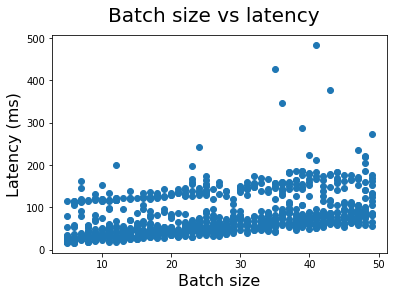

In [7]:
#Creating Batch size vs latency plot
fig = plt.figure()
plt.scatter(batches, times)
fig.suptitle('Batch size vs latency', fontsize=20)
plt.xlabel('Batch size', fontsize=16)
plt.ylabel('Latency (ms)', fontsize=16)
plt.show()
#Change the filename as needed
fig.savefig('batch_latency_randop_1000.jpg')